In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
sns.set_style("whitegrid")

from deepmd.infer import DeepPot
from mlptools.io.read import read_from_dp_data, read_from_lmp_dump
from mlptools.descriptor.dp import get_descriptor_vector, get_predictions
from mlptools.utils.constants import ZERO_POINT_ENERGY

Instructions for updating:
non-resource variables are not supported in the long term


/home/y1u0d2/anaconda3/envs/deepmd/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
/home/y1u0d2/anaconda3/envs/deepmd/lib/python3.10/site-packages/ovito/extensions/averaging.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? Note that this will likely lead to conflicts with existing libraries in the Anaconda environment, and loading of the OVITO module may subsequently fail with an error related to the Qt framework. In such a case, please uninstall the OVITO pip package first by running 'pip uninstall -y ovito PySide2 PySide6' and then install the OVITO for Anaconda package using the correct command: 

    conda install --strict-channel-priority -c https://conda.ovito.org -c conda-forge ovito

Visit https://w

In [2]:
path2target = '/home/y1u0d2/result/deepmd/Si/35'
e_test_files = glob(f'{path2target}/test_*.e.out')
e_train_files = glob(f'{path2target}/train_*.e.out')
f_test_files = glob(f'{path2target}/test_*.f.out')
f_train_files = glob(f'{path2target}/train_*.f.out')

print(len(e_test_files), len(e_train_files), len(f_train_files), len(f_test_files))

10 10 10 10


In [3]:
for f in f_test_files:
    mpid = '_'.join(f.split('/')[-1].split('.')[0].split('_')[1:])
    print(mpid)

mp-92_32
mp-slab_56
mp-571520_24
mp-1079649_16
mp-four_4
mp-165_32
mp-149_64
mp-149_8
mp-three_3
mp-149_dimer_2


In [4]:
def get_mpid(file):
    return '_'.join(file.split('/')[-1].split('.')[0].split('_')[1:])

# def get_energy_df(e_files):
#     all_e_result = []
#     for e_file in e_files:
#         n_atom = int(e_file.split('/')[-1].split('.')[0].split('_')[-1])
#         e_array = np.loadtxt(e_file, dtype=float, skiprows=1)
#         mpid = get_mpid(e_file)
#         print(mpid)
#         all_e_result.append(np.hstack([e_array, np.array([[n_atom] for i in range(e_array.shape[0])]), np.array([[mpid] for _ in range(e_array.shape[0])], dtype=str)]))
#     print(all_e_result[0])
#     all_e_result = np.vstack(all_e_result)
#     all_e_result_df = pd.DataFrame(data=all_e_result, columns=['obs_e', 'pred_e', 'n_atoms', 'mpid'])
#     all_e_result_df['obs_e_atom'] = all_e_result_df['obs_e'] / all_e_result_df['n_atoms']
#     all_e_result_df['pred_e_atom'] = all_e_result_df['pred_e'] / all_e_result_df['n_atoms']
#     return all_e_result_df

In [5]:
def get_energy_df(e_files):
    all_e_result = []
    for e_file in e_files:
        n_atom = int(e_file.split('/')[-1].split('.')[0].split('_')[-1])
        e_array = np.loadtxt(e_file, dtype=float, skiprows=1)
        each_e_df = pd.DataFrame(
                        data=np.hstack([e_array, np.array([[n_atom] for i in range(e_array.shape[0])])]),
                        columns=['obs_e', 'pred_e', 'n_atoms']
                    )
        each_e_df['mpid'] = get_mpid(e_file)
        all_e_result.append(each_e_df)
    all_e_result_df = pd.concat(all_e_result)
    all_e_result_df['obs_e_atom'] = all_e_result_df['obs_e'] / all_e_result_df['n_atoms']
    all_e_result_df['pred_e_atom'] = all_e_result_df['pred_e'] / all_e_result_df['n_atoms']
    return all_e_result_df

In [6]:
all_train_e_result = get_energy_df(e_train_files)
all_test_e_result = get_energy_df(e_test_files)

print(f'train shape: {all_train_e_result.shape}')
print(f'test shape: {all_test_e_result.shape}')

train shape: (49526, 6)
test shape: (5509, 6)


In [7]:
def plot_obs_pred(df, title, unit):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    obs = df['obs_e_atom']
    pred = df['pred_e_atom']
    max_val = max(obs.max(), pred.max())
    min_val = min(obs.min(), pred.min())
    linspace = np.linspace(min_val, max_val, 10)

    sns.scatterplot(data=df, x='obs_e_atom', y='pred_e_atom', alpha=0.3, color='blue', ax=ax)
    # sns.scatterplot(data=df, x='obs_e_atom', y='pred_e_atom', hue='mpid')

    ax.scatter(obs, pred, alpha=0.2)
    ax.plot(linspace, linspace, color='red')
    ax.set_title(title)
    ax.set_xlabel('Eobs [eV]')
    ax.set_ylabel('Epred [eV]')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    fig.show()

OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-31
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 32 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #192: KMP_AFFINITY: 1 socket x 32 cores/socket x 1 thread/core (32 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 2 maps to socket 0 core 2 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 3 maps to socket 0 core 3 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 4 maps to socket 0 core 4 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 5 maps to socket 0 core 5 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 6 maps to socket 0 core 6 thread 0 
OMP: Info #172: KMP_AFFINITY: O

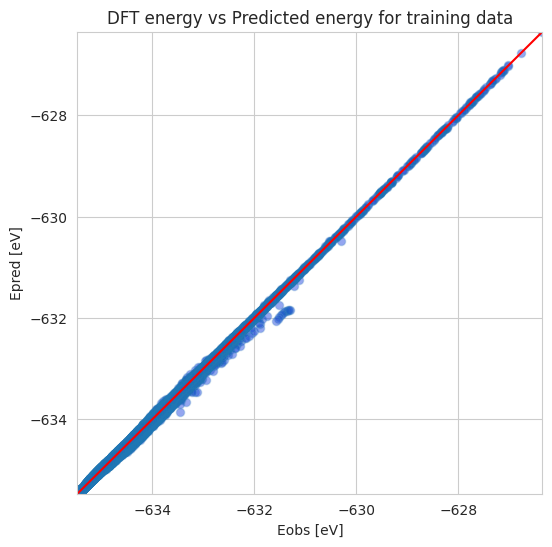

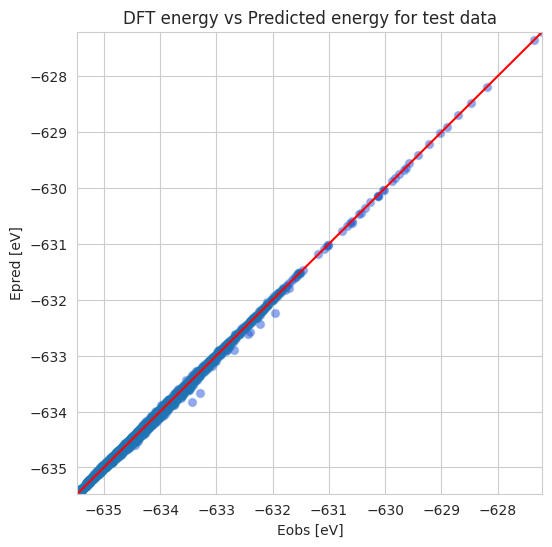

In [8]:
plot_obs_pred(
    df=all_train_e_result,
    title='DFT energy vs Predicted energy for training data',
    unit='eV'
    )

plot_obs_pred(
    df=all_test_e_result,
    title='DFT energy vs Predicted energy for test data',
    unit='eV'
    )

In [9]:
def get_force_df(f_files):
    all_force = []
    for f_file in f_files:
        force_df = pd.DataFrame(
            data=np.loadtxt(f_file, dtype=float, skiprows=1),
            columns=['obs_fx', 'obs_fy', 'obs_fz', 'pred_fx', 'pred_fy', 'pred_fz']
        )
        force_df['mpid'] = get_mpid(f_file)
        all_force.append(force_df)
    return pd.concat(all_force)

In [10]:
# all_train_f_result = np.vstack([np.loadtxt(f_file, dtype=float, skiprows=1) for f_file in f_train_files])
# all_test_f_result = np.vstack([np.loadtxt(f_file, dtype=float, skiprows=1) for f_file in f_test_files])
all_train_f_result_df = get_force_df(f_train_files)
all_test_f_result_df = get_force_df(f_test_files)

In [11]:
all_train_f_result_df.shape, all_test_f_result_df.shape

((770826, 7), (85826, 7))

In [12]:
# columns = ['obs_fx', 'obs_fy', 'obs_fz', 'pred_fx', 'pred_fy', 'pred_fz']
# all_train_f_result_df = pd.DataFrame(data=all_train_f_result, columns=columns)
# all_test_f_result_df = pd.DataFrame(data=all_test_f_result, columns=columns)

In [13]:
def plot_obs_pred_force(df, title, unit):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    obs = df[[col for col in df.columns if 'obs' in col]].values.ravel()
    pred = df[[col for col in df.columns if 'pred' in col]].values.ravel()
    max_val = max(obs.max(), pred.max())
    min_val = min(obs.min(), pred.min())
    linspace = np.linspace(min_val, max_val, 10)

    # sns.scatterplot(data=df, x='obs_fx', y='pred_fx', hue='mpid')
    sns.scatterplot(data=df, x='obs_fx', y='pred_fx', alpha=0.3, color='blue', ax=ax)
    # sns.scatterplot(data=df, x='obs_fy', y='pred_fy', hue='mpid')
    # sns.scatterplot(data=df, x='obs_fz', y='pred_fz', hue='mpid')

    ax.scatter(obs, pred, alpha=0.2)
    ax.plot(linspace, linspace, color='red')
    ax.set_title(title)
    ax.set_xlabel('Fobs [eV/A]')
    ax.set_ylabel('Fpred [eV/A]')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    fig.show()

In [14]:
all_test_f_result_df

,obs_fx,obs_fy,obs_fz,pred_fx,pred_fy,pred_fz,mpid
0,0.845325,-1.184674,0.856841,1.205670,-1.332860,0.960157,mp-92_32
1,-0.266362,0.032517,0.236945,-0.301188,0.012901,0.260869,mp-92_32
2,0.187059,0.375511,-0.156478,0.043588,0.426025,-0.194622,mp-92_32
3,0.553312,0.764391,0.112156,0.188556,0.680667,0.322677,mp-92_32
4,0.257731,0.253884,-0.076832,0.198725,0.463875,-0.035404,mp-92_32
...,...,...,...,...,...,...,...
3,0.462454,0.000000,0.000000,-0.420002,0.000000,0.000000,mp-149_dimer_2
4,2.442316,0.000000,0.000000,1.583194,0.000000,0.000000,mp-149_dimer_2
5,-2.442316,0.000000,0.000000,-1.583194,0.000000,0.000000,mp-149_dimer_2
6,2.286698,0.000000,0.000000,1.893580,0.000000,0.000000,mp-149_dimer_2


/tmp/ipykernel_3003514/2751920238.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_3003514/2751920238.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


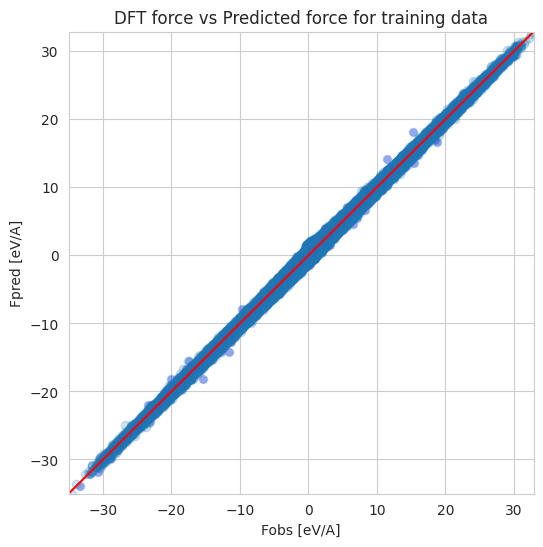

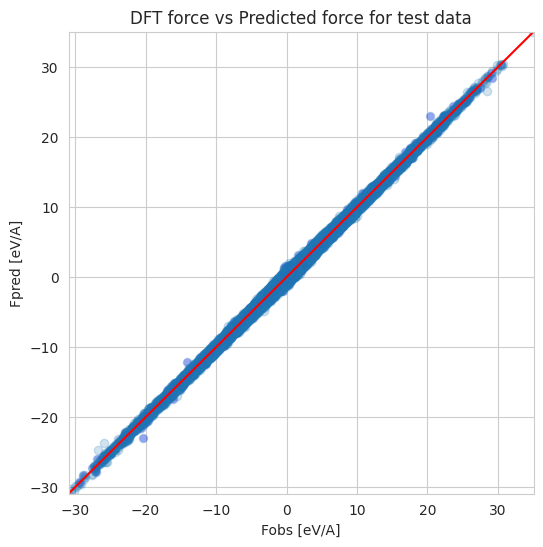

In [15]:
plot_obs_pred_force(
    df=all_train_f_result_df,
    title='DFT force vs Predicted force for training data',
    unit='eV/ang'
)

plot_obs_pred_force(
    df=all_test_f_result_df,
    title='DFT force vs Predicted force for test data',
    unit='eV/ang'
)

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calc_all_metrics(obs, pred, unit):
    print(f'shape of obs:{obs.shape}, pred:{pred.shape}')
    print(f'MAE: {mean_absolute_error(obs, pred)} [{unit}]')
    print(f'RMSE: {np.square(mean_squared_error(obs, pred))} [{unit}]')
    print(f'R2: {r2_score(obs, pred)}')

In [17]:
# For energy
print('Energy for training data')
calc_all_metrics(
    obs=all_train_e_result['obs_e'],
    pred=all_train_e_result['pred_e'],
    unit='eV'
)

print('-'*30)
print('Energy for test data')
calc_all_metrics(
    obs=all_test_e_result['obs_e'],
    pred=all_test_e_result['pred_e'],
    unit='eV'
)

Energy for training data
shape of obs:(49526,), pred:(49526,)
MAE: 0.25437076161320404 [eV]
RMSE: 0.01847186732409611 [eV]
R2: 0.9999999981819803
------------------------------
Energy for test data
shape of obs:(5509,), pred:(5509,)
MAE: 0.2510744060535916 [eV]
RMSE: 0.017376604505133553 [eV]
R2: 0.999999998241516


In [18]:
# For force
print('Force for training data')
columns = all_train_f_result_df.columns

calc_all_metrics(
    obs=all_train_f_result_df[[col for col in columns if 'obs' in col]].values.ravel(),
    pred=all_train_f_result_df[[col for col in columns if 'pred' in col]].values.ravel(),
    unit='eV/A'
)

print('-'*30)
print('Force for test data')
calc_all_metrics(
    obs=all_test_f_result_df[[col for col in columns if 'obs' in col]].values.ravel(),
    pred=all_test_f_result_df[[col for col in columns if 'pred' in col]].values.ravel(),
    unit='eV/A'
)

Force for training data
shape of obs:(2312478,), pred:(2312478,)
MAE: 0.15234053287673735 [eV/A]
RMSE: 0.0018795387548043478 [eV/A]
R2: 0.9972294924080729
------------------------------
Force for test data
shape of obs:(257478,), pred:(257478,)
MAE: 0.1515059988172879 [eV/A]
RMSE: 0.001864535840078078 [eV/A]
R2: 0.9972537786929474


In [19]:
# plot dimer result
path2model = os.path.join(path2target, 'graph.pb')
path2data = os.path.join(path2target, 'data')
path2test = os.path.join(path2data, 'test')
path2train = os.path.join(path2data, 'train')

model = DeepPot(path2model)

all_atoms = []
for path in glob(f'{path2test}/mp*'):
    all_atoms += read_from_dp_data(os.path.join(path, 'set.000'), additional_info='test')

for path in glob(f'{path2train}/mp*'):
    all_atoms += read_from_dp_data(os.path.join(path, 'set.000'), additional_info='train')

all_dimer = [atoms for atoms in all_atoms if atoms.structure_id =='mp-149_dimer']

2023-04-26 14:46:58.164901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 14:46:58.379725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 14:46:58.380043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 14:46:58.413855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [20]:
result = []
for atoms in all_dimer:
    distance = atoms.get_atomic_distance()
    pred_energy, _, _ = get_predictions(atoms, model=model)
    result.append([distance, atoms.energy, pred_energy[0][0], atoms.additional_info])

energy_df = pd.DataFrame(data=result, columns=['distance', 'obs', 'pred', 'type'])
energy_df['obs_shift'] = energy_df['obs'] - 2 * ZERO_POINT_ENERGY
energy_df['pred_shift'] = energy_df['pred'] - 2 * ZERO_POINT_ENERGY
energy_df = energy_df.sort_values(by='distance').reset_index(drop=True)

/tmp/ipykernel_3003514/2355227799.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


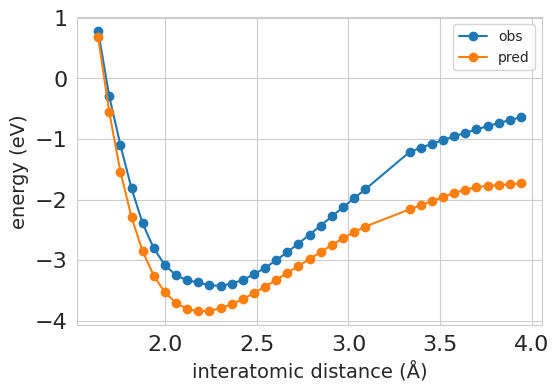

In [21]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
fs = 14

ax.plot(energy_df['distance'], energy_df['obs_shift'], label='obs', marker='o')
ax.plot(energy_df['distance'], energy_df['pred_shift'], label='pred', marker='o')

ax.legend()

ax.set_xlabel('interatomic distance (Å)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

fig.show()

/tmp/ipykernel_3003514/3347187524.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


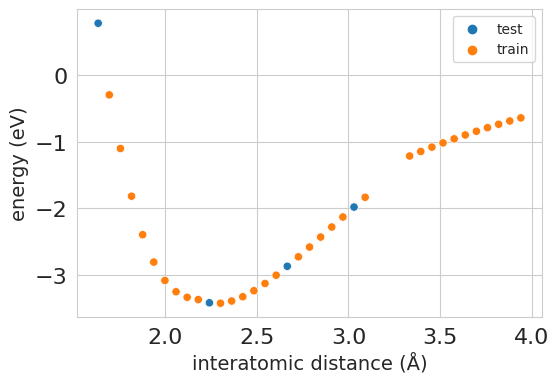

In [22]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
fs = 14

sns.scatterplot(data=energy_df, x='distance', y='obs_shift', hue='type', markers='o')

ax.legend()

ax.set_xlabel('interatomic distance (Å)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

fig.show()